# III. Harmonizing Year Name Formulae and Processing Dates

We now will convert the date field to a series of numerical entries representing the year, month, and day, as well as various special values, recorded on the tablet. This will allow us to perform time analysis on the data.

In [ ]:
# import necessary libraries
import pandas as pd

In [ ]:
words_df = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_2_output.p') # uncomment to read from online file
#words_df = pd.read_pickle('output/part_2_output.p') #uncomment to read from local file

catalogue_data = pd.read_pickle('https://gitlab.com/yashila.bordag/sumnet-data/-/raw/main/part_1_catalogue.p')
#catalogue_data = pd.read_pickle('output/part_1_catalogue.p')

,date_of_origin,dates_referenced,collection,primary_publication,museum_no,provenience,metadata_source
P100041,SSXX - 00 - 00,SSXX - 00 - 00,"Louvre Museum, Paris, France",AAS 053,AO 20313,Puzriš-Dagān,BDTNS
P100189,SH46 - 08 - 05,SH46 - 08 - 05,"Louvre Museum, Paris, France",AAS 211,AO 20039,Puzriš-Dagān,BDTNS
P100190,SH47 - 07 - 29,SH47 - 07 - 29,"Louvre Museum, Paris, France",AAS 212,AO 20051,Puzriš-Dagān,BDTNS
P100191,AS01 - 03 - 24,AS01 - 03 - 24,"Louvre Museum, Paris, France",AAS 213,AO 20074,Puzriš-Dagān,BDTNS
P100211,AS01 - 12 - 11,AS01 - 12 - 11,"Museum of Fine Arts, Budapest, Hungary","ActSocHun Or 5-12, 156 2",MHBA 51.2400,Puzriš-Dagān,BDTNS
...,...,...,...,...,...,...,...
P456164,NaN,NaN,NaN,CDLI Seals 003454 (composite),NaN,Puzriš-Dagan (mod. Drehem),ORACC
P459158,Ibbi-Suen.00.00.00,Ibbi-Suen.00.00.00,"private: anonymous, unlocated",CDLI Seals 006338 (physical),Anonymous 459158,Puzriš-Dagan (mod. Drehem),ORACC
P481391,SH46 - 02 - 24,SH46 - 02 - 24,"Department of Classics, University of Cincinna...",unpublished unassigned ?,UC CSC 1950,Puzriš-Dagān,BDTNS
P481395,SS02 - 02 - 00,SS02 - 02 - 00,"Department of Classics, University of Cincinna...",unpublished unassigned ?,UC CSC 1954,Puzriš-Dagān,BDTNS


## 1 Normalizing BDTNS Dates

In the ORACC metadata the field `date_of_origin` is formatted as `Amar-Suen.05.10.03`, meaning "5th regnal year of Amar-Suen; month 10, day 3". The ORACC metadata are directly imported from CDLI. In general, BDTNS metadata tend to be more reliable than CDLI metadata. As such, wherever possible we will use the BDTNS date rather than the CDLI date. 

However, the strings for the dates are formatted differently in BDTNS. If the date were the same as the example given above, in the BDTNS format it would be represented by the string `AS05 - 10 - 03`. Moreover, BDTNS dates can sometimes contain additional information, like if the month was a diri month, or multiple dates on the same tablet. When present, this information could be of value later on, so we attempt to include as much of it as possible. In the following we will write two functions, the first to convert from BDTNS format to several numerical and boolean fields and the second to do the same for the CDLI format.

In [ ]:
def inner_normalize_bdtns_date(bdtns_date):
      # the normalized time each king's reign began, with Ur-Namma's first year
      # of rule as year 0.
      reigns = {
                'UN' : 0, 
                'SH' : 18, 
                'AS': 66, 
                'SS' : 75, 
                'IS' : 84
                }
    
      # Sometimes a date string contains multiple dates seperated by '//'.
      # In such a case we set the range of dates to go from the earliest
      # date to the latest date.
      if '//' in bdtns_date:
          dates = [normalize_bdtns_date(date) for date in bdtns_date.split('//')]
          return {
            'min_year': min([date['min_year'] for date in dates]),
            'max_year': max([date['max_year'] for date in dates]),
            'min_month': min([date['min_month'] for date in dates]),
            'max_month': max([date['max_month'] for date in dates]),
            'diri_month': any([date['diri_month'] for date in dates]),
            'min_day': min([date['min_day'] for date in dates]),
            'max_day': max([date['max_day'] for date in dates]),
            'questionable': any([date['questionable'] for date in dates]),
            'other_meta_chars': any([date['other_meta_chars'] for date in dates]),
            'multiple_dates': True
          }

      # there are several characters used as markers for metatextual information
      # we remove them from our string and handle them seperately.
      chars = ' d?]m+()l'
      reduced_string = bdtns_date.upper()
      for c in chars.upper():
        reduced_string = reduced_string.replace(c, '')
      date_list = reduced_string.split('-')
      date_list = ['nan' if 'XX' in s else s for s in date_list]
      try:
        year = reigns[date_list[0][:2]] + float(date_list[0][-2:])
      except KeyError:
        year = float('nan')
      month = float(date_list[1])
      try:
        day = float(date_list[2])
      except IndexError:
        day = float('nan')
      return {
              'min_year': year,
              'max_year': year + 1,
              'min_month': month,
              'max_month': month + 1,
              'diri_month': 'd' in bdtns_date,
              'min_day': day,
              'max_day': day + 1,
              'questionable': '?' in bdtns_date,
              'other_meta_chars': any([c in bdtns_date for c in chars[3:]]),
              'multiple_dates': False
            }

# Lastly, we define a wrapper function to catch any errors thrown by our main function.
# This is useful because the string was manually entered, so there are many edge cases,
# each with only a few instances.
def normalize_bdtns_date(bdtns_date):
  try:
    return inner_normalize_bdtns_date(bdtns_date)
  except:
    return {
                  'min_year' : None,
                  'max_year' : None,
                  'min_month' : None,
                  'max_month' : None,
                  'min_day' : None,
                  'max_day' : None,
                  'diri_month' : None,
                  'questionable' : None,
                  'other_meta_chars': None,
                  'multiple_dates' : None
    }

## 2 Normalizing CDLI Date Strings

The next step is to convert the CDLI string representing the date into a numerical format. For months and days, this process is relatively straightforward: so long as the entry is legible we can convert the substring into a number. If it is illegible, we set it to `None`.

When it comes to the year, however, the process is a bit more involved. Since the year number in the date string represents the year of the current king's reign, it does not by itself give us the absolute year. We account for this by adding the year the king began his reign to the year given in the date. The table below contains the values used to achieve this.

| king | normalized years | regnal years|
| ----- | ---------------- | ---------- |
| Ur-Namma    | 1-18  |  18 |
| Šulgi      | 19-66 |  48 |
| Amar-Suen   | 67-75  |  9 |
| Šū-Suen    | 76-84  |  9 |
| Ibbi-Suen   | 85-108 | 24 |

In [ ]:
def normalize_cdli_date(cdli_date):
      # the normalized time each king's reign began, with Ur-Namma's first year
      # of rule as year 0.
      reigns = {'Ur-Namma' : 0, 
                'Šulgi' : 18, 
                'Amar-Suen': 66, 
                'Šū-Suen' : 75, 
                'Ibbi-Suen' : 84 
                }

      # break if NaN or None (this means the date is illegible)
      if type(cdli_date) is not str: 
        out = {
                  'min_year' : None,
                  'max_year' : None,
                  'min_month' : None,
                  'max_month' : None,
                  'min_day' : None,
                  'max_day' : None,
                  'diri_month' : None,
                  'questionable' : None,
                  'other_meta_chars': None,
                  'multiple_dates' : None
        }
        return out

      decomposed_date = cdli_date.split('.')
      decomposed_date[0] = reigns.get(decomposed_date[0])
      if decomposed_date[0] is None:
        decomposed_date[0] = float('nan')

      # if a section of the year/month/day is illegible we replace that entry with NaN,
      # otherwise we convert it to a float.
      decomposed_date[1:] = list(map(lambda x: float(x) if x.isdigit() else float('nan'), decomposed_date[1:]))
      try:
        out = {
                  'min_year' : decomposed_date[0] + decomposed_date[1],
                  'max_year' : decomposed_date[0] + decomposed_date[1] + 1,
                  'min_month' : decomposed_date[2],
                  'max_month' : decomposed_date[2] + 1,
                  'min_day' : decomposed_date[3],
                  'max_day' : decomposed_date[3] + 1,
                  'diri_month' : False,
                  'questionable' : False,
                  'other_meta_chars': False,
                  'multiple_dates' : False
        }
        return out

      except: # due to some edge cases in the formatting, the list can occasionally
              # have length shorter than 4. If so, the date is partially illegible
              # and can be ignored.
        out = {
                  'min_year' : None,
                  'max_year' : None,
                  'min_month' : None,
                  'max_month' : None,
                  'min_day' : None,
                  'max_day' : None,
                  'diri_month' : None,
                  'questionable' : None,
                  'other_meta_chars': None,
                  'multiple_dates' : None
        }
        return out

## 3 Putting it all Together

Now that we have a way to convert our strings in either format, we are ready to apply it to the data. To do this we will

1.   loop through each row of the input DataFrame
2.   use the `metadata_source` field to determine the format of the date string
3.   apply the appropriate function to the `date_of_origin` field to get a dictionary of our new fields
4.   compile the results for each row into a list



In [ ]:
def add_normalized_columns(df):
  row_list = []
  # go through each row of the DataFrame
  for index in df.index:
    # get the date_of_origin string
    date = df['date_of_origin'][index]
    # select the appropriate function to convert using metadata_source
    if df['metadata_source'][index] == 'BDTNS':
      row = normalize_bdtns_date(date)
    else:
      row = normalize_cdli_date(date)
    row['metadata_source'] = df['metadata_source'][index]
    # add the result to a list
    row_list.append(row)
  return row_list

Next, we process the dates given in `catalogue_data`. From this we will both add the information to our `words_df` variable, as well as include it in a standalone variable, `time_data`.

In [ ]:
 result = add_normalized_columns(catalogue_data)
 time_data = pd.DataFrame(result, index=catalogue_data.index)
 words_df = words_df.merge(time_data, left_on='id_text', right_index=True)

At this stage, we can already get a bit more insight into our data using our newly added fields. For example, we can look at the number of tablets over time - even removing cases with uncertain or multiple dates.

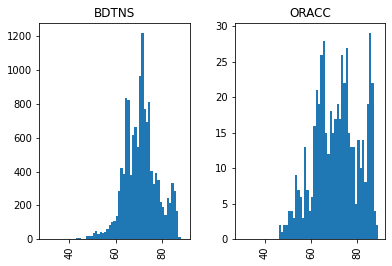

In [ ]:
ax = time_data[(time_data['questionable'] == False)].hist(column='min_year', by='metadata_source', sharex=True, bins= range(30, 90))

## 4 Save Results in CSV file and Pickle
Here we will save the `words_df` and `time_data` outputs from parts 1, 2, and 3.

In [ ]:
words_df.to_csv('output/part_3_words_output.csv')
words_df.to_pickle('output/part_3_words_output.p')

time_data.to_csv('output/part_3_time_output.csv')
time_data.to_pickle('output/part_3_time_output.p')